# [How to Record Fiber Response](https://portwooddigital.com/2021/07/25/how-to-record-fiber-response/) ([Prof.  Michael H. Scott](https://portwooddigital.com/author/staticsprof/))

In this jupyter notebook we take a look to the mentioned review and implement it by some small changes.

By: [Bijan Sayyafzadeh](linkedin.com/in/bijan-sayyafzadeh-6027aa7a) [Email](B.sayyaf@yahoo.com) [Github](https://github.com/BijanSeif)

The main pupose of the review is how to deal with fibers data and get results from them. The below model has been generated for this purpose:

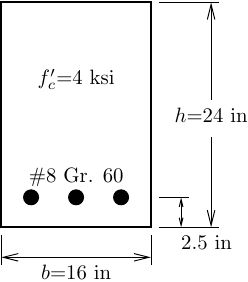

Description of the model by Prof. Scott:

*Using a zeroLengthSection element with displacement control on the nodal rotation, we know the curvature is the nodal rotation and the moment is the load factor. The model uses basic material models–Concrete01 with standard inputs for compressive and spalling strains, and EPP Steel01–for the fibers.*

In [2]:
import openseespy.opensees as ops

kip = 1.0
inch = 1.0

ft = 12*inch
ksi = kip/inch**2

fc = 4*ksi
fy = 60*ksi
E = 29000*ksi

Abar = 0.79*inch**2

h = 24*inch
b = 16*inch

ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0,0); ops.fix(1,1,1,1)
ops.node(2,0,0); ops.fix(2,0,1,0)

ops.uniaxialMaterial('Concrete01',1,fc,0.002,0,0.006)
ops.uniaxialMaterial('Steel01',2,fy,E,0)

ops.section('Fiber',1)
ops.patch('rect',1,8,1,-h/2,-b/2,h/2,b/2)
ops.layer('straight',2,3,Abar,-h/2+2.5*inch,b/2-2.5*inch,-h/2+2.5*inch,-b/2+2.5*inch)

ops.element('zeroLengthSection',1,1,2,1)

ops.timeSeries('Linear',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0,1)

Ky = 0.003/(h/2) # ballpark estimate of yield curvature
ops.integrator('DisplacementControl',2,3,Ky/100)

# create the analysis
ops.wipeAnalysis()                     # clear previously-define analysis parameters
ops.constraints('Plain')               # how it handles boundary conditions
ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGeneral')              # how to store and solve the system of equations in the analysis
ops.algorithm('Linear')                # use Linear algorithm for linear analysis
ops.integrator("LoadControl", 0.1)     # create integrator
ops.analysis("Static")                 # create analysis object


epsc = 0
AllData=[]
while epsc > -0.003:
    ops.analyze(1)
    epsc = ops.nodeDisp(2,1) - h/2*ops.nodeDisp(2,3)
    
    #Get All Fiber Data From OpenSees:
    data=ops.eleResponse(1,'section','fiberData') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'
    AllData.append(data)

## Now, Different results can be calclulated:
* Moment step
* Moment curvature
* Step - Fibers Strain
* Step - Concrete Fibers Stress
* Step - Rebars Fibers Stress



<IPython.core.display.Javascript object>


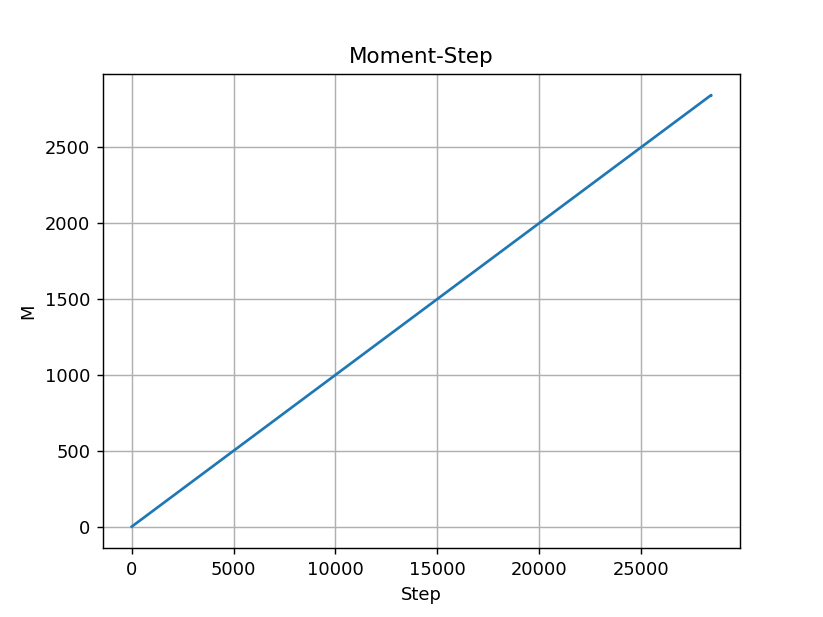

<IPython.core.display.Javascript object>


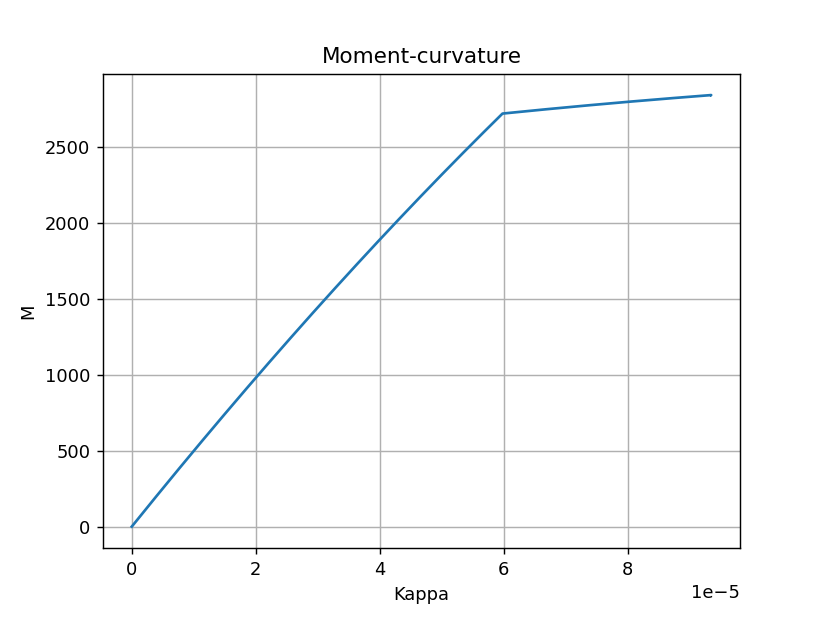

<IPython.core.display.Javascript object>


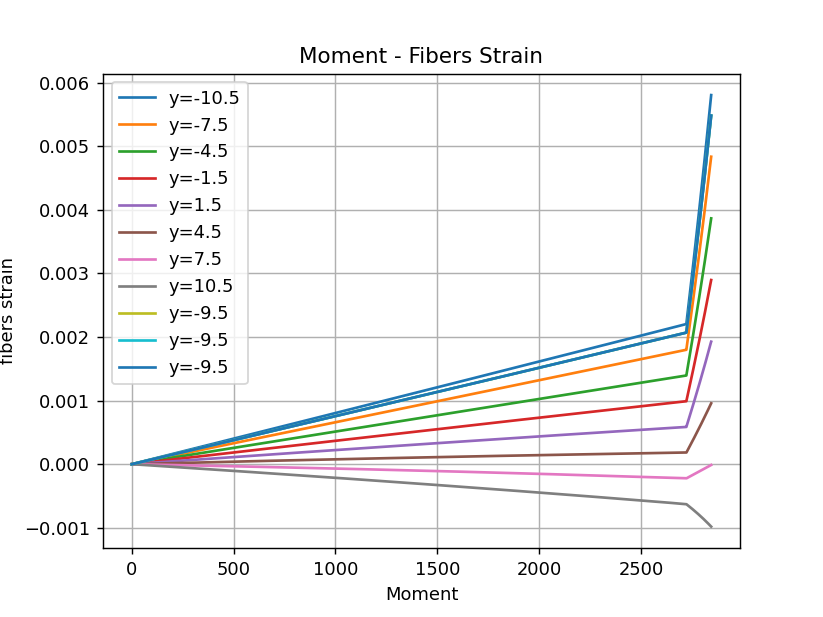

<IPython.core.display.Javascript object>


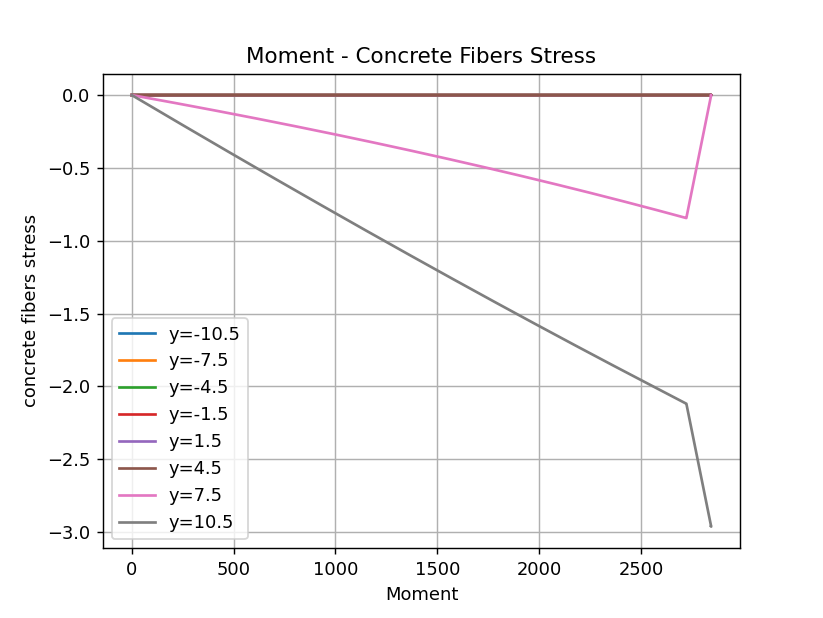

<IPython.core.display.Javascript object>


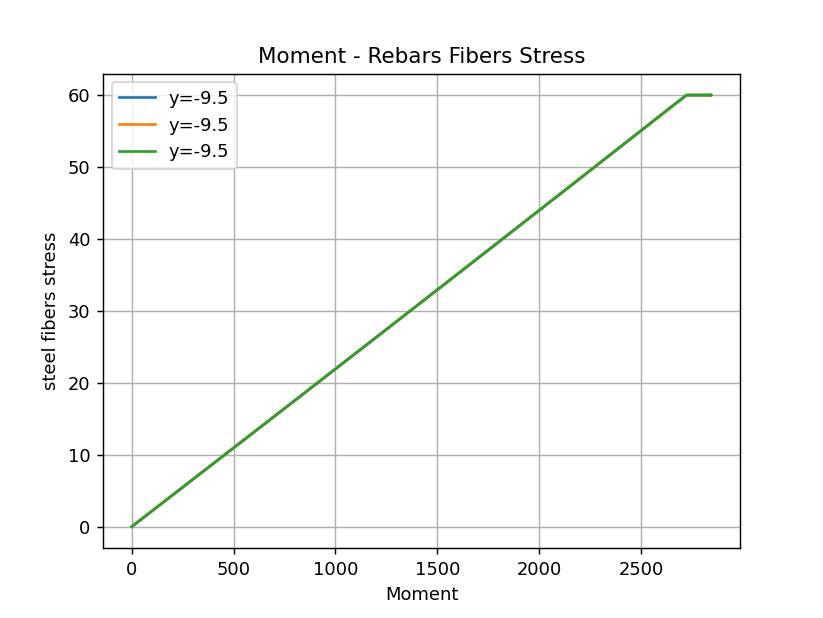

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import math
import scipy as sc

#     data=ops.eleResponse(1,'section','fiberData') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'

#Store Different data in lists
step=[]
y=[]
z=[]
A=[]
sig=[]
consig=[]
stlsig=[]
eps=[]
M=[]
K=[]

for st,data in enumerate(AllData):
    step.append(st)
    Ndata = len(data)
    Nfibers = int(Ndata/5)
    #print(Ndata)    
    #print('Nfibers=',Nfibers, '\n')


    y=data[0:Ndata:5] # Get Fibers y local location
    z=data[1:Ndata:5] # For 2D models z is always equal to zero
    A=data[2:Ndata:5] # If you want each fiber areas

    # print('\ny=',(y[-1]),'\nz=',z[-1])
    # print('A=',A[-1],'\n')


    sig.append(data[3:Ndata:5]) # Get fibers stress
    eps.append(data[4:Ndata:5]) # Get fibers strain 
    
    # print('sig=',sig[-1])
    # print('eps=',(eps[-1]))  
    epsmin=min(eps[-1])
    K.append(epsmin/y[eps[-1].index(epsmin)]) # Calculate section curvature
    
    consig.append(sig[-1][0:-3])
    stlsig.append(sig[-1][-3:])

    #print('#= [ y   , z  , A   , sig, eps                  ]')
    #for i in range(11):
    #    print(f'{i}=',data[i*5:(i+1)*5])


    M.append(sum([yi*ai*sigi for yi,ai,sigi in zip(y,A,sig[-1])]))
    #print('\nM=',M[-1])


fig=0
plt.figure(fig)
plt.plot(step,[abs(m) for m in M])
plt.xlabel('Step')
plt.ylabel('M');
plt.title('Moment-Step')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(k) for k in K],[abs(m) for m in M])
plt.xlabel('Kappa')
plt.ylabel('M');
plt.title('Moment-curvature')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M][0:-1],eps[0:-1])
plt.xlabel('Moment')
plt.ylabel('fibers strain');
plt.title('Moment - Fibers Strain')
plt.legend([f'y={yi}' for yi in y])
plt.grid()

fig=fig+1
plt.figure(fig)
sig=consig
plt.plot([abs(m) for m in M],sig)
plt.xlabel('Moment')
plt.ylabel('concrete fibers stress');
plt.title('Moment - Concrete Fibers Stress')
plt.legend([f'y={yi}' for yi in y[0:-3]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M],stlsig)
plt.xlabel('Moment')
plt.ylabel('steel fibers stress');
plt.title('Moment - Rebars Fibers Stress')
plt.legend([f'y={yi}' for yi in y[-3:]])
plt.grid()
